# Experiment to train a binary classifier on a CPV division

The idea is to obtain 45 balanced datasets from OpenTender data to train 45 independent binary classifiers.

The balanced dataset is created using [this dataset](https://s3.console.aws.amazon.com/s3/object/d-ew1-ted-ai-experiments-data?region=eu-west-1&prefix=CPVs/202310/all_english_notices/20231020-all_EN_notices_tedAI.csv).

In [3]:
import math
import re
from pathlib import Path

import joblib
import optuna
import pandas as pd
import spacy.cli
from matplotlib import pyplot as plt
from sklearn import metrics, model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from tqdm import tqdm
from unidecode import unidecode

ROOT_PATH = Path("tmp") / "20231031_balanced_dataset"
ROOT_PATH.mkdir(exist_ok=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Experiment dataset balancing

In [4]:
df = pd.read_csv("tmp/20231031-en-dataset-lvl12.csv", dtype={"id": str, "text": str})
train_df, test_df = model_selection.train_test_split(df, test_size=0.2, random_state=0)
train_df, validation_df = model_selection.train_test_split(
    train_df, test_size=0.2, random_state=0
)
division = "45"
divisions = [c for c in df.columns if len(c) == 2 and c.isdigit()]

In [5]:
df.head()

id                                               text  313  188  \
0  658980-2021   extension cullahill community centre storey e...    0    0   
1  398421-2018   supply material associated manage service pfh...    0    0   
2  398209-2018   catalyst building shell core work constructio...    0    0   
3  380679-2018   nhdcNUMBER assistive technology installation ...    0    0   
4  381633-2018   food product vegetables fruit berry NUMBER ne...    0    0   

   80  729  315  156  425  651  ...  75  763  146  339  751  432  246  383  \
0   0    0    0    0    0    0  ...   0    0    0    0    0    0    0    0   
1   0    0    0    0    1    0  ...   0    0    0    0    0    0    1    0   
2   0    0    0    0    0    0  ...   0    0    0    0    0    0    0    0   
3   0    0    0    0    0    0  ...   0    0    0    0    0    0    0    0   
4   0    0    0    0    0    0  ...   0    0    0    0    0    0    0    0   

   66  191  
0   0    0  
1   0    0  
2   0    0  
3   0    0  
4   0    0  

[5 rows x 319 columns]

In [6]:
def balance_df(df_: pd.DataFrame, pos_div: str, neg_div_ratio: float) -> pd.DataFrame:
    pos_count = (df_[pos_div] == 1).sum()
    neg_count_per_div = pos_count * neg_div_ratio
    neg_divisions = [div for div in divisions if div != pos_div]
    neg_dfs = [filter_neg_div_df(df_, div, neg_count_per_div) for div in neg_divisions]
    pos_df = df_[df_[pos_div] == 1]
    balanced_df = pd.concat(neg_dfs + [pos_df])
    return balanced_df.drop_duplicates()


def filter_neg_div_df(df_: pd.DataFrame, neg_div: str, neg_count: int) -> pd.DataFrame:
    groups = [c for c in df_.columns if len(c) == 3 and c.startswith(neg_div)]
    count_per_group = math.ceil(neg_count / len(groups))
    return pd.concat([df_[df_[group] == 1].head(count_per_group) for group in groups])

In [7]:
neg_div_ratio = 0.1
final_train_df = balance_df(train_df, division, neg_div_ratio)

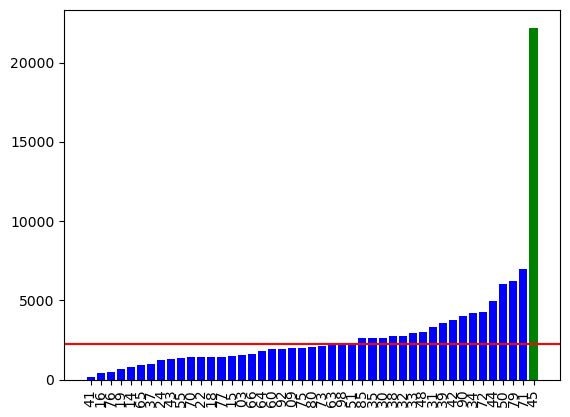

In [8]:
stats = sorted(
    (
        (d, (final_train_df[d] == 1).sum(), "green" if d == division else "blue")
        for d in divisions
    ),
    key=lambda x: x[1],
)
plt.axhline(y=(final_train_df[division] == 1).sum() * neg_div_ratio, color="red")
plt.bar([s[0] for s in stats], [s[1] for s in stats], color=[s[2] for s in stats])
plt.xticks(rotation=90)
plt.show()

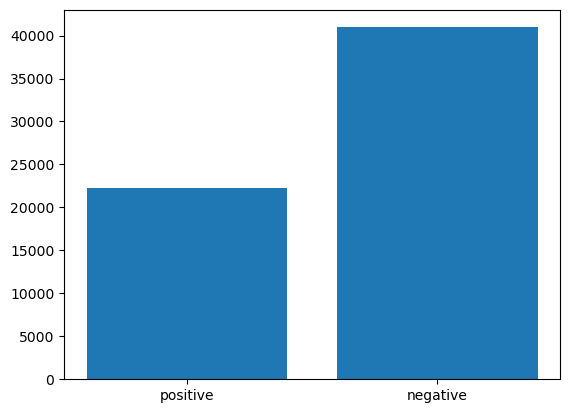

In [9]:
plt.bar(
    ["positive", f"negative"],
    [(final_train_df[division] == 1).sum(), (final_train_df[division] == 0).sum()],
)
plt.show()

## Train a model on CPV division 45

45 is chosen because it is quite rich (9 CPV groups) and contains a significant amount of data.

In [10]:
def balance_df(df_: pd.DataFrame, pos_div: str, neg_div_ratio: float) -> pd.DataFrame:
    divisions = [c for c in df_.columns if len(c) == 2 and c.isdigit()]
    pos_count = (df_[pos_div] == 1).sum()
    neg_count_per_div = pos_count * neg_div_ratio
    neg_divisions = [div for div in divisions if div != pos_div]
    neg_dfs = [filter_neg_div_df(df_, div, neg_count_per_div) for div in neg_divisions]
    pos_df = df_[df_[pos_div] == 1]
    balanced_df = pd.concat(neg_dfs + [pos_df])
    return balanced_df.drop_duplicates()
    

def filter_neg_div_df(df_: pd.DataFrame, neg_div: str, neg_count: int) -> pd.DataFrame:
    groups = [c for c in df_.columns if len(c) == 3 and c.startswith(neg_div)]
    count_per_group = math.ceil(neg_count / len(groups))
    return pd.concat([df_[df_[group] == 1].head(count_per_group) for group in groups])

In [11]:
def train(trial: optuna.Trial, division: str) -> float:
    df = pd.read_csv(
        "tmp/20231031-en-dataset-lvl12.csv", dtype={"id": str, "text": str}
    )
    train_df, test_df = model_selection.train_test_split(
        df, test_size=0.2, random_state=0
    )
    del df
    train_df, validation_df = model_selection.train_test_split(
        train_df, test_size=0.2, random_state=0
    )
    neg_div_ratio = trial.suggest_float("neg_div_ratio", 0.1, 1.0)
    final_train_df = balance_df(train_df, division, neg_div_ratio)
    del train_df
    model = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, trial.suggest_int("ngram_range", 2, 3)),
                    min_df=trial.suggest_int("min_df", 1, 4),
                    max_df=trial.suggest_float("max_df", 0.2, 1.0),
                ),
            ),
            (
                "clf",
                LinearSVC(
                    max_iter=10000,
                    C=trial.suggest_float("C", 0.1, 10),
                    random_state=0,
                ),
            ),
        ]
    )
    model.fit(final_train_df["text"], final_train_df[division])
    predicted_df = model.predict(final_train_df["text"])
    scores = metrics.precision_recall_fscore_support(
        final_train_df[division], predicted_df, average="binary"
    )
    precision, recall, f1_score, _ = scores
    trial.set_user_attr("train precision", precision)
    trial.set_user_attr("train recall", recall)
    trial.set_user_attr("train f1_score", f1_score)
    predicted_df = model.predict(test_df["text"])
    scores = metrics.precision_recall_fscore_support(
        test_df[division], predicted_df, average="binary"
    )
    precision, recall, f1_score, _ = scores
    trial.set_user_attr("test precision", precision)
    trial.set_user_attr("test recall", recall)
    trial.set_user_attr("test f1_score", f1_score)
    predicted_df = model.predict(validation_df["text"])
    scores = metrics.precision_recall_fscore_support(
        validation_df[division], predicted_df, average="binary"
    )
    precision, recall, f1_score, _ = scores
    trial.set_user_attr("validation precision", precision)
    trial.set_user_attr("validation recall", recall)
    trial.set_user_attr("validation f1_score", f1_score)
    return f1_score


division = "45"
Path("tmp/20231109_training_{division}.db").unlink(missing_ok=True)
study = optuna.create_study(
    direction="maximize", storage=f"sqlite:///tmp/20231109_training_{division}.db"
)
with joblib.parallel_backend("multiprocessing"):
    study.optimize(lambda trial: train(trial, division), n_trials=3, n_jobs=1)
study.trials_dataframe().to_csv(f"tmp/20231109_trials_1_{division}.csv", index=False)

[I 2023-11-22 10:00:43,550] A new study created in RDB with name: no-name-99ff5f84-5976-428e-9f14-109110b7cfcd
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
[I 2023-11-22 10:01:18,188] Trial 0 finished with value: 0.7722989662427958 and parameters: {'neg_div_ratio': 0.4072113598639395, 'ngram_range': 3, 'min_df': 4, 'max_df': 0.6585425114679234, 'C': 0.5395976279359335}. Best is trial 0 with value: 0.7722989662427958.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
[I 2023-11-22 10:01:55,079] Trial 1 finished with value: 0.7737469330529267 and parameters: {'neg_div_rati

In [12]:
pd.read_csv(f"tmp/20231109_trials_1_{division}.csv")

number     value              datetime_start           datetime_complete  \
0       0  0.772299  2023-11-22 10:00:43.558712  2023-11-22 10:01:18.170673   
1       1  0.773747  2023-11-22 10:01:18.195028  2023-11-22 10:01:55.066133   
2       2  0.791279  2023-11-22 10:01:55.086209  2023-11-22 10:02:53.337371   

                 duration  params_C  params_max_df  params_min_df  \
0  0 days 00:00:34.611961  0.539598       0.658543              4   
1  0 days 00:00:36.871105  4.300478       0.304324              3   
2  0 days 00:00:58.251162  9.611256       0.605032              1   

   params_neg_div_ratio  params_ngram_range  user_attrs_test f1_score  \
0              0.407211                   3                  0.763229   
1              0.395076                   3                  0.763798   
2              0.486953                   3                  0.785867   

   user_attrs_test precision  user_attrs_test recall  \
0                   0.776051                0.750823   
1                   0.739474                0.789775   
2                   0.757033                0.816984   

   user_attrs_train f1_score  user_attrs_train precision  \
0                   0.939474                    0.972361   
1                   0.998379                    0.998829   
2                   0.999977                    1.000000   

   user_attrs_train recall  user_attrs_validation f1_score  \
0                 0.908739                        0.772299   
1                 0.997930                        0.773747   
2                 0.999955                        0.791279   

   user_attrs_validation precision  user_attrs_validation recall     state  
0                         0.781233                      0.763567  COMPLETE  
1                         0.750340                      0.798661  COMPLETE  
2                         0.761069                      0.823987  COMPLETE

In [ ]:
def train(trial: optuna.Trial, division: str) -> float:
    df = pd.read_csv(
        "tmp/20231031-en-dataset-lvl12.csv", dtype={"id": str, "text": str}
    )
    train_df, test_df = model_selection.train_test_split(
        df, test_size=0.2, random_state=0
    )
    del df
    train_df, validation_df = model_selection.train_test_split(
        train_df, test_size=0.2, random_state=0
    )
    neg_div_ratio = trial.suggest_float("neg_div_ratio", 0.1, 2.0)
    final_train_df = balance_df(train_df, division, neg_div_ratio)
    del train_df
    model = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, 3),
                    min_df=trial.suggest_int("min_df", 1, 2),
                    max_df=trial.suggest_float("max_df", 0.1, 0.8),
                ),
            ),
            (
                "clf",
                LinearSVC(
                    max_iter=10000,
                    C=trial.suggest_float("C", 0.1, 10),
                    random_state=0,
                ),
            ),
        ]
    )
    model.fit(final_train_df["text"], final_train_df[division])
    predicted_df = model.predict(final_train_df["text"])
    scores = metrics.precision_recall_fscore_support(
        final_train_df[division], predicted_df, average="binary"
    )
    precision, recall, f1_score, _ = scores
    trial.set_user_attr("train precision", precision)
    trial.set_user_attr("train recall", recall)
    trial.set_user_attr("train f1_score", f1_score)
    predicted_df = model.predict(test_df["text"])
    scores = metrics.precision_recall_fscore_support(
        test_df[division], predicted_df, average="binary"
    )
    precision, recall, f1_score, _ = scores
    trial.set_user_attr("test precision", precision)
    trial.set_user_attr("test recall", recall)
    trial.set_user_attr("test f1_score", f1_score)
    predicted_df = model.predict(validation_df["text"])
    scores = metrics.precision_recall_fscore_support(
        validation_df[division], predicted_df, average="binary"
    )
    precision, recall, f1_score, _ = scores
    trial.set_user_attr("validation precision", precision)
    trial.set_user_attr("validation recall", recall)
    trial.set_user_attr("validation f1_score", f1_score)
    return f1_score


division = "45"
Path("tmp/20231109_training_{division}.db").unlink(missing_ok=True)
study = optuna.create_study(
    direction="maximize", storage=f"sqlite:///tmp/20231109_training_{division}.db"
)
with joblib.parallel_backend("multiprocessing"):
    study.optimize(lambda trial: train(trial, division), n_trials=3, n_jobs=1)
study.trials_dataframe().to_csv(f"tmp/20231109_trials_2_{division}.csv", index=False)

In [25]:
pd.read_csv(f"tmp/20231109_trials_2_{division}.csv")

number     value              datetime_start           datetime_complete  \
0        0  0.869571  2023-11-10 15:54:10.610965  2023-11-10 16:02:23.755432   
1        1  0.873843  2023-11-10 15:54:10.616395  2023-11-10 16:02:44.181454   
2        2  0.836593  2023-11-10 15:54:10.643811  2023-11-10 16:00:39.110521   
3        3  0.878025  2023-11-10 15:54:10.644379  2023-11-10 16:02:54.073833   
4        4  0.877343  2023-11-10 15:54:10.670530  2023-11-10 16:02:51.708801   
5        5  0.875606  2023-11-10 15:54:10.686447  2023-11-10 16:02:49.167830   
6        6  0.877707  2023-11-10 15:54:10.702585  2023-11-10 16:00:43.793728   
7        7  0.872210  2023-11-10 15:54:10.724104  2023-11-10 16:02:42.816934   
8        8  0.836736  2023-11-10 16:00:56.936611  2023-11-10 16:06:52.186033   
9        9  0.869453  2023-11-10 16:01:01.325592  2023-11-10 16:06:14.824820   
10      10  0.870934  2023-11-10 16:02:31.315623  2023-11-10 16:10:10.325435   
11      11  0.875154  2023-11-10 16:02:47.026212  2023-11-10 16:10:34.359545   
12      12  0.819554  2023-11-10 16:02:48.737820  2023-11-10 16:09:06.111208   
13      13  0.874266  2023-11-10 16:02:50.993028  2023-11-10 16:10:45.224534   
14      14  0.879025  2023-11-10 16:02:53.097797  2023-11-10 16:11:02.254081   
15      15  0.874643  2023-11-10 16:02:54.156965  2023-11-10 16:11:15.150224   
16      16  0.879113  2023-11-10 16:06:34.110517  2023-11-10 16:17:24.418584   
17      17  0.879304  2023-11-10 16:07:07.497619  2023-11-10 16:17:43.296139   
18      18  0.879384  2023-11-10 16:09:16.313972  2023-11-10 16:19:15.386467   
19      19  0.879329  2023-11-10 16:10:16.752708  2023-11-10 16:19:53.349456   
20      20  0.879246  2023-11-10 16:10:38.826532  2023-11-10 16:20:47.069915   
21      21  0.879236  2023-11-10 16:10:48.088848  2023-11-10 16:20:53.910925   
22      22  0.879335  2023-11-10 16:11:03.927990  2023-11-10 16:20:57.175627   
23      23  0.879113  2023-11-10 16:11:15.231148  2023-11-10 16:21:18.995711   
24      24  0.879157  2023-11-10 16:17:39.504564  2023-11-10 16:28:25.704222   
25      25  0.878779  2023-11-10 16:17:52.011160  2023-11-10 16:28:49.802314   
26      26  0.879044  2023-11-10 16:19:24.667304  2023-11-10 16:29:19.682247   
27      27  0.879143  2023-11-10 16:20:00.045945  2023-11-10 16:29:43.814036   
28      28  0.879172  2023-11-10 16:20:52.392048  2023-11-10 16:29:50.363512   
29      29  0.879172  2023-11-10 16:20:56.227898  2023-11-10 16:29:59.639459   
30      30  0.879019  2023-11-10 16:20:59.842919  2023-11-10 16:29:35.332296   
31      31  0.878786  2023-11-10 16:21:19.069898  2023-11-10 16:33:37.139719   
32      32  0.879151  2023-11-10 16:28:44.517675  2023-11-10 16:37:58.810047   
33      33  0.879571  2023-11-10 16:29:00.831863  2023-11-10 16:38:55.955991   
34      34  0.879531  2023-11-10 16:29:26.944076  2023-11-10 16:39:22.252529   
35      35  0.878623  2023-11-10 16:29:41.673983  2023-11-10 16:39:15.676834   
36      36  0.879166  2023-11-10 16:29:47.690505  2023-11-10 16:39:28.246909   
37      37  0.879462  2023-11-10 16:29:52.396613  2023-11-10 16:39:29.897154   
38      38  0.879438  2023-11-10 16:29:59.707715  2023-11-10 16:42:13.807150   
39      39  0.878106  2023-11-10 16:34:07.257075  2023-11-10 16:45:57.832759   
40      40  0.877551  2023-11-10 16:38:13.636205  2023-11-10 16:47:59.692363   
41      41  0.877551  2023-11-10 16:39:04.537090  2023-11-10 16:48:23.800436   
42      42  0.877659  2023-11-10 16:39:21.426277  2023-11-10 16:48:25.895157   
43      43  0.878175  2023-11-10 16:39:26.893017  2023-11-10 16:48:23.715561   
44      44  0.877851  2023-11-10 16:39:28.312446  2023-11-10 16:48:31.601807   
45      45  0.877713  2023-11-10 16:39:29.979366  2023-11-10 16:48:58.510917   
46      46  0.879206  2023-11-10 16:42:27.969101  2023-11-10 16:52:15.162298   
47      47  0.879191  2023-11-10 16:46:13.100664  2023-11-10 16:53:29.678893   
48      48  0.879260  2023-11-10 16:48:11.253118  2023-11-10 16:53:38.010303   
49  